In [1]:
"""
General imports and loading of the audio file for development and explorative research.
The audio signal is normalized in the time domain to its highest value.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import taunet_utils
%run transient_shaper_lib.ipynb

SAMPLE_LENGTH = 10

audio_data_path = os.path.join(os.getcwd(), "dataset", "audio")
audio_data_with_labels = taunet_utils.read_audio_files(audio_data_path, truncate_at=SAMPLE_LENGTH)

print("Audio data and labels:")
for audio_data, label, sample_rate in audio_data_with_labels:
  print(f"- Label: {label}, Audio data shape: {audio_data.shape}, Sample rate: {sample_rate}")

FRAME_LEN = 1   # in s


Audio data and labels:
- Label: 1 - looperman-l-5151565-0354397-spicy-drums, Audio data shape: (185762,), Sample rate: 48000


In [2]:
sampleRate = 48000 
BEAT_DETECTION_BUFFER_SIZE = 64
AUDIO_BUFFER_SIZE_S = 8
AUDIO_BUFFER_SIZE = sampleRate * AUDIO_BUFFER_SIZE_S
MAX_ONSETS = 4 * AUDIO_BUFFER_SIZE_S # 4 BPS IS 240 BPM


from ctypes import *
from typing import Literal
lib = CDLL("../src/af/AFInC.dll")  # Adjust path accordingly

lib.resetBuffer.argtypes = []
lib.resetBuffer.restype = None

lib.initAf.argtypes = []
lib.initAf.restype = None

lib.AFInCAppend.argtypes = [c_double]
lib.AFInCAppend.restype = None

lib.AFInCProcess.argtypes = []
lib.AFInCProcess.restype = None

lib.processBTTAndAFInC.argtypes = []
lib.processBTTAndAFInC.restype = None

lib.afGetT1A.argtypes = []
lib.afGetT1A.restype = c_double

lib.afGetT2A.argtypes = []
lib.afGetT2A.restype = c_double

lib.afGetTempo.argtypes = []
lib.afGetTempo.restype = c_double

lib.afGetSpectralCentroid.argtypes = []
lib.afGetSpectralCentroid.restype = c_double

lib.afGetPBandL.argtypes = []
lib.afGetPBandL.restype = c_double

lib.afGetPBandML.argtypes = []
lib.afGetPBandML.restype = c_double

lib.afGetPBandMH.argtypes = []
lib.afGetPBandMH.restype = c_double

lib.afGetPBandH.argtypes = []
lib.afGetPBandH.restype = c_double

lib.afGetCrestFactor.argtypes = []
lib.afGetCrestFactor.restype = c_double

lib.afGetSpectralFlux.argtypes = []
lib.afGetSpectralFlux.restype = c_double

# ----------------------------------------
# debug helpers
# ----------------------------------------
lib.__getAudioBuffer.argtypes = []
lib.__getAudioBuffer.restype = c_double

lib.__getEnvBuffer.argtypes = []
lib.__getEnvBuffer.restype = c_double

lib.__getOnsetBuffer.argtypes = []
lib.__getOnsetBuffer.restype = c_double

lib.__getTA1Buffer.argtypes = []
lib.__getTA1Buffer.restype = c_double

lib.__getTA2Buffer.argtypes = []
lib.__getTA2Buffer.restype = c_double

lib.__getBeatMagnitude.argtypes = [c_int]
lib.__getBeatMagnitude.restype = c_double

lib.__resetIndexDebug.argtypes = []
lib.__resetIndexDebug.restype = None

1 - looperman-l-5151565-0354397-spicy-drums
--- AF in C features ---
Tempo:  0.7769337016574586
TA1:  0.73625
TA2:  3.1471428571428572
Spectral centroid: 0.3275863698739784
EQ Low:  0.07418019035407264 
EQ MidLow:  0.09720012886456901 
EQ MidHigh:  0.09563096119537434 
EQ High:  0.007000944814098307 
Crest Factor: 0.10166459076845731
Spectral Flux:  0.0034939196109771728
-------
TA1 python percentile:  0.012291666666666666
TA2 python percentile::  0.229828125
32
(32, 512)


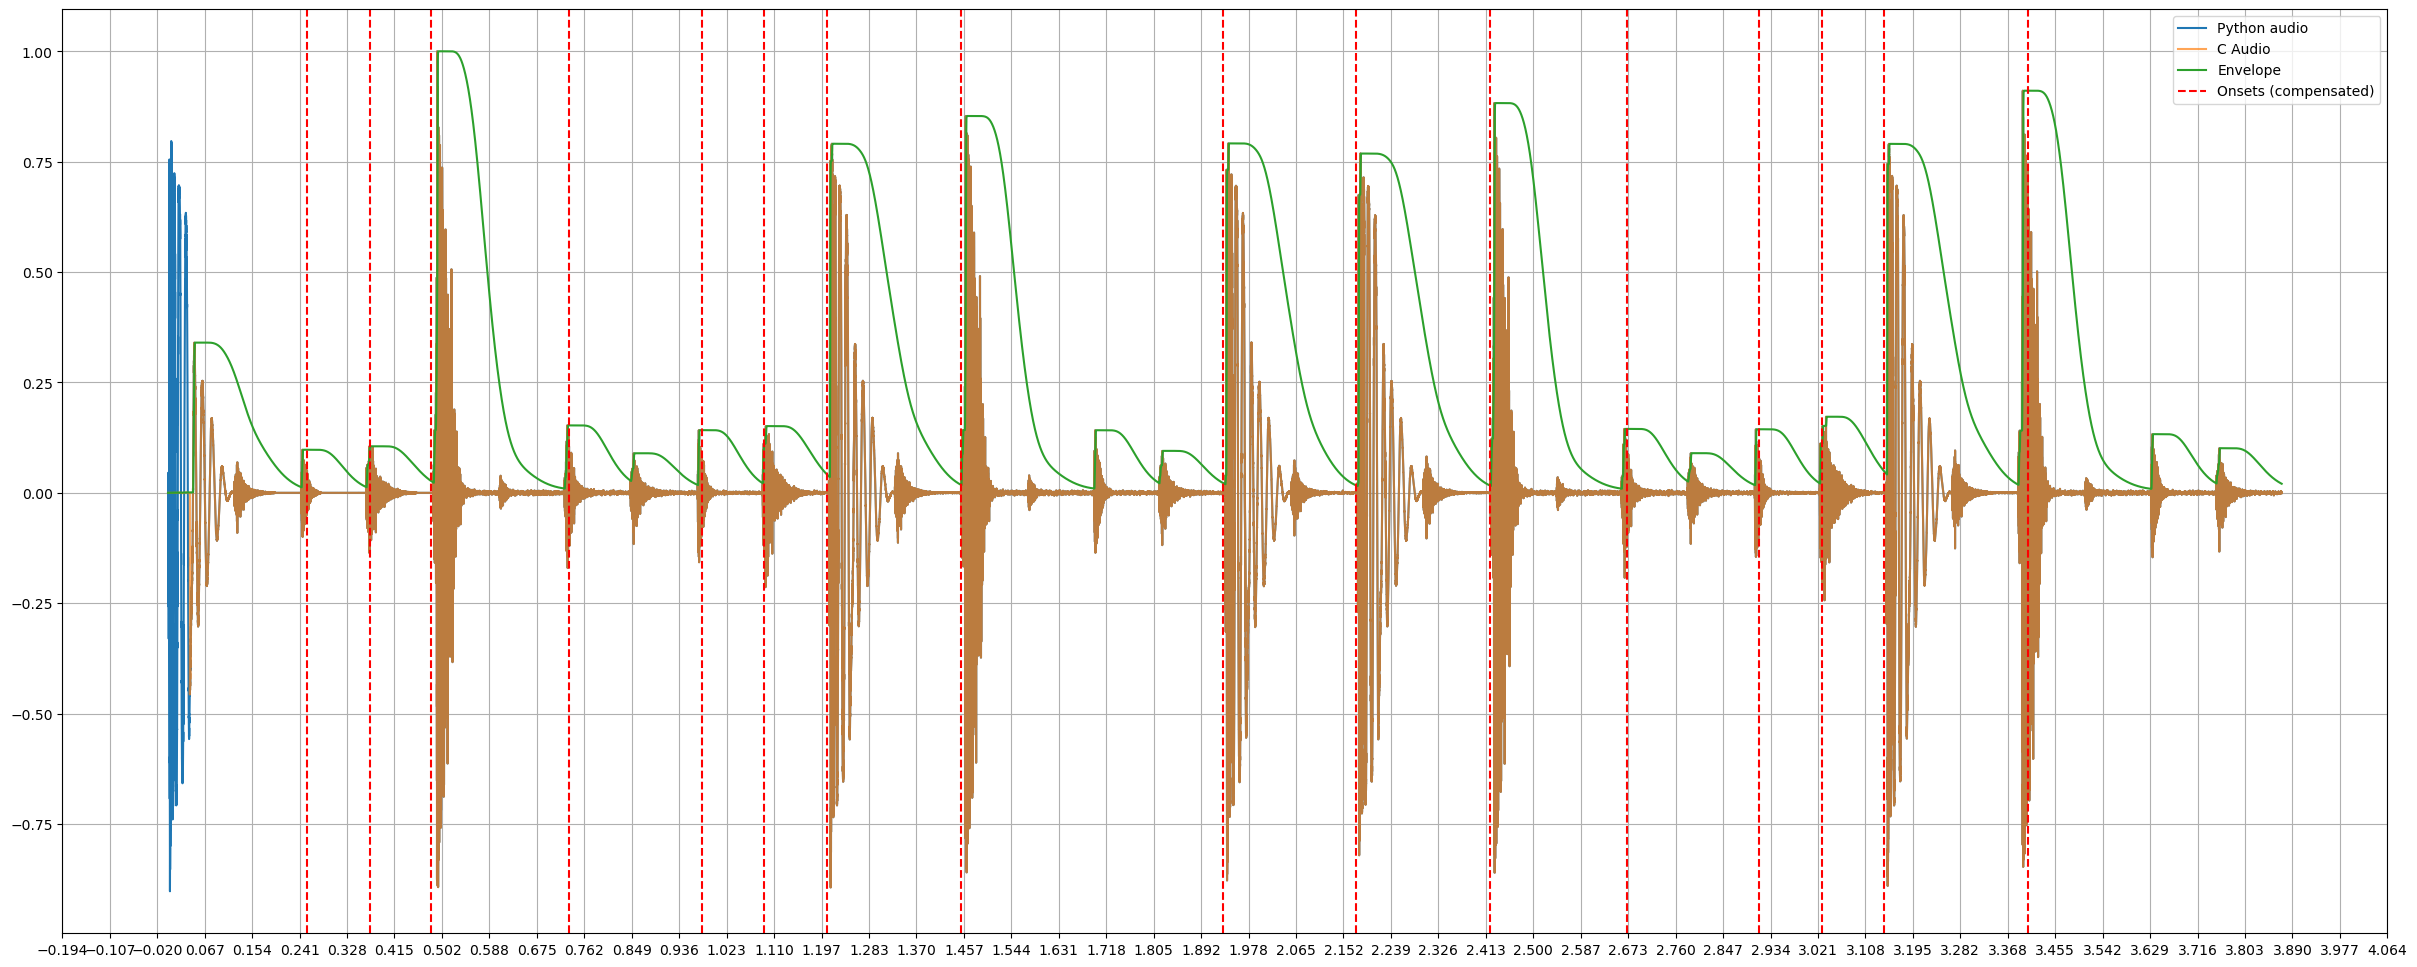

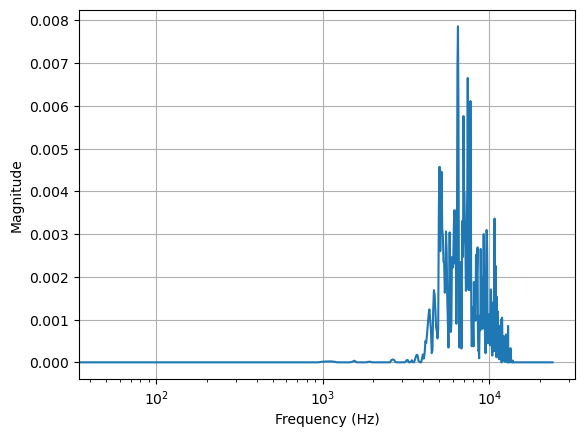

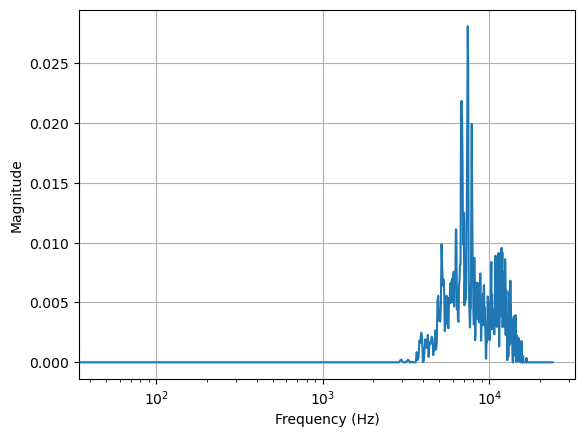

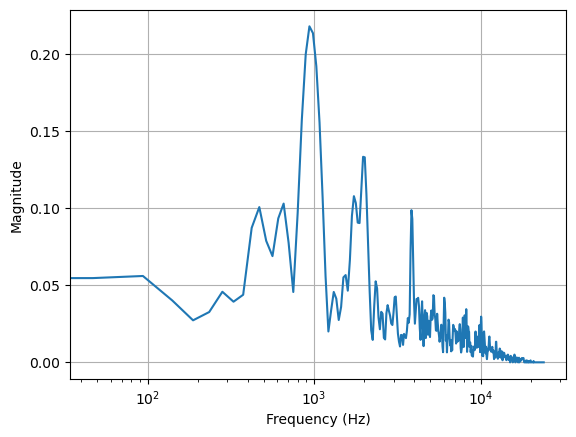

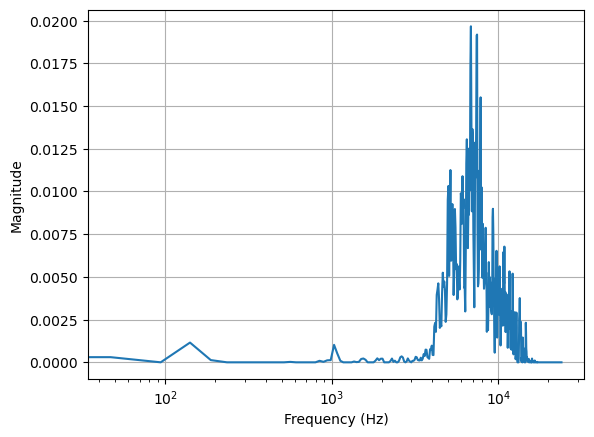

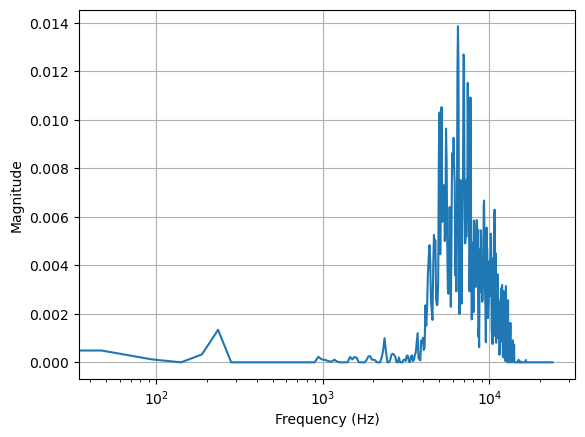

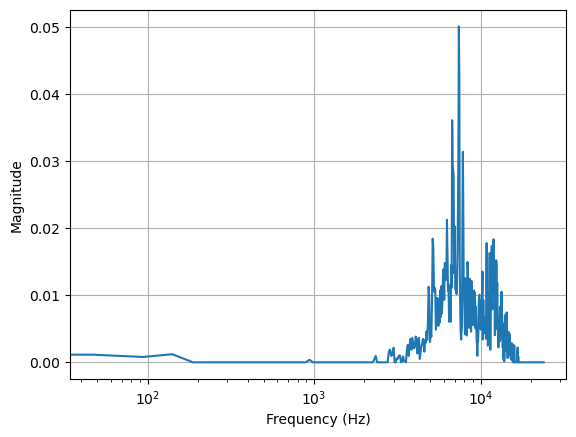

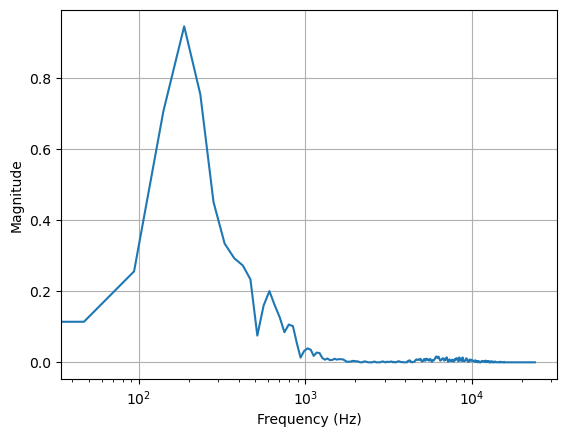

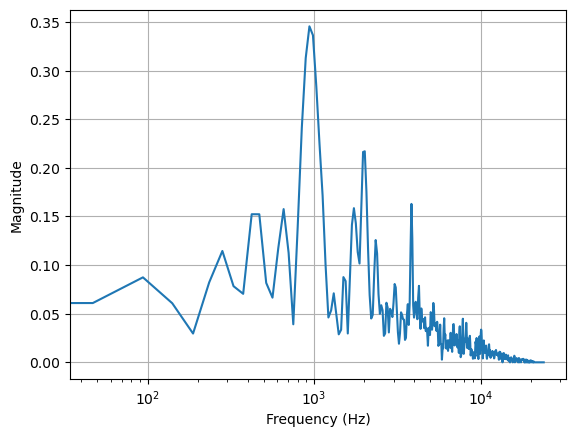

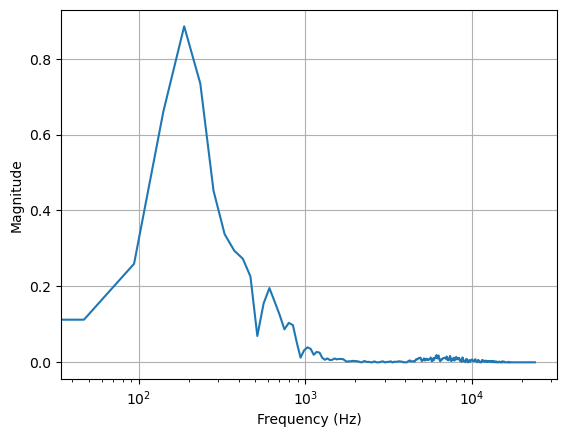

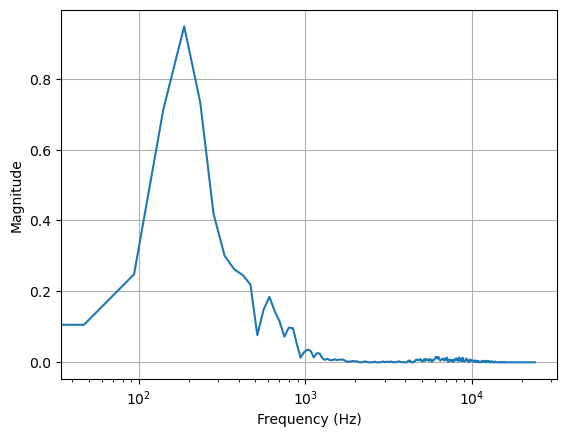

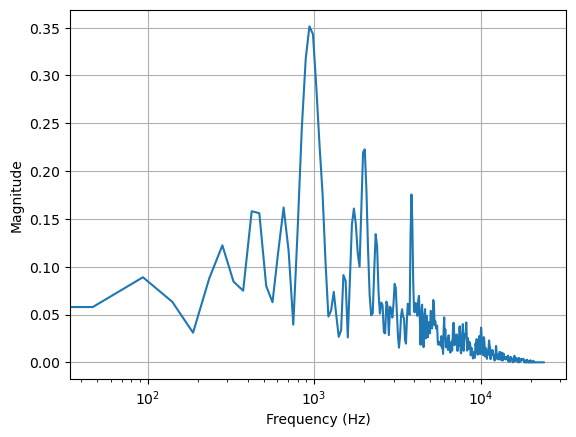

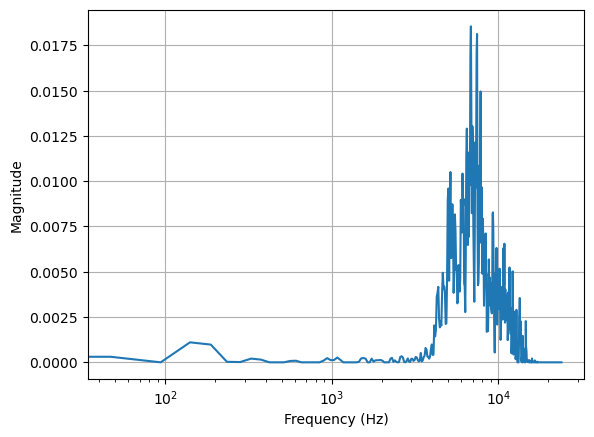

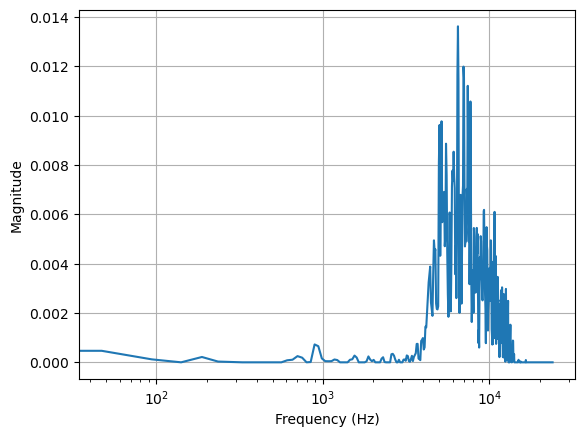

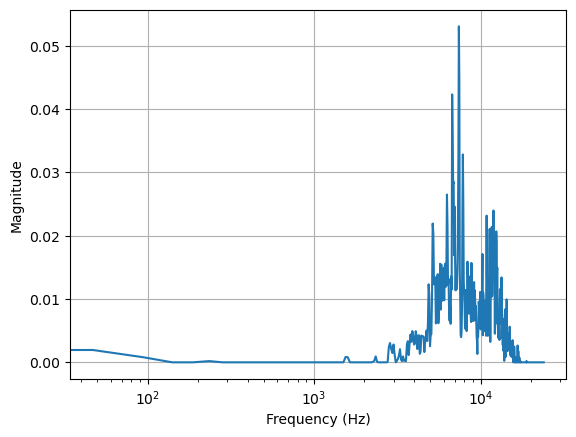

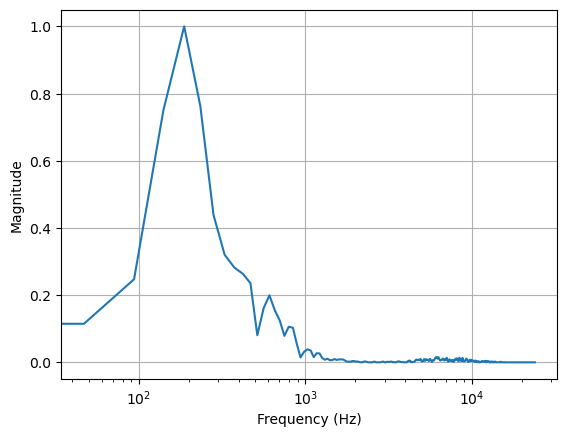

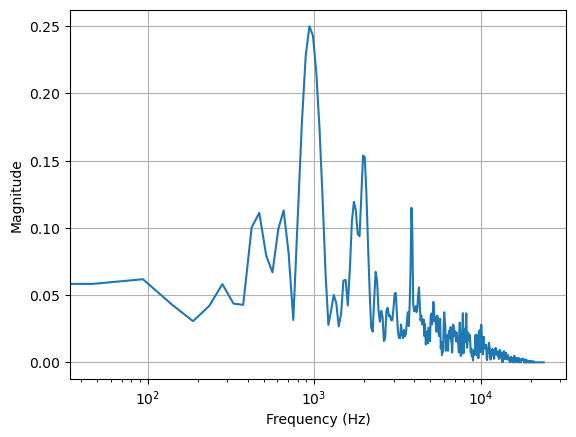

In [3]:
for song in audio_data_with_labels:
    lib.__resetIndexDebug()

    target_device_audio_buffer = []
    envelope = []
    onsets = []
    TA1Buffer = []
    TA2Buffer = []
    magnitudePerBeat = np.zeros((512 * MAX_ONSETS // 512, 512))
    lib.initAf()
    lib.resetBuffer()

    print(song[1])
    for sample in song[0]:
        lib.AFInCAppend(sample)

    lib.processBTTAndAFInC()
    
    print("--- AF in C features ---")
    print("Tempo: ", lib.afGetTempo())
    print("TA1: ", lib.afGetT1A())
    print("TA2: ", lib.afGetT2A())
    print("Spectral centroid:", (lib.afGetSpectralCentroid()))
    print("EQ Low: ", lib.afGetPBandL(), "")
    print("EQ MidLow: ", lib.afGetPBandML(), "")
    print("EQ MidHigh: ", lib.afGetPBandMH(), "")
    print("EQ High: ", lib.afGetPBandH(), "")
    print("Crest Factor:", lib.afGetCrestFactor())
    print("Spectral Flux: ", lib.afGetSpectralFlux())
    print("-------")
    
    for sample in song[0]:
        target_device_audio_buffer.append(lib.__getAudioBuffer())
        envelope.append(lib.__getEnvBuffer())
    
    for onset in range(MAX_ONSETS):
        currentOnset = lib.__getOnsetBuffer()
        if(currentOnset == 0):
            break
        currentTA1 = lib.__getTA1Buffer() / sample_rate
        curretnTA2 = lib.__getTA2Buffer() / sample_rate
        onsets.append(currentOnset)
        TA1Buffer.append(currentTA1)
        TA2Buffer.append(curretnTA2)

    print("TA1 python percentile: ", np.percentile(TA1Buffer, 75))
    print("TA2 python percentile:: ", np.percentile(TA2Buffer, 75))
    print(len(magnitudePerBeat))
    for perBeat, value in enumerate(onsets):
        for bin in range(0,512):
            magnitudePerBeat[perBeat,bin] = lib.__getBeatMagnitude(perBeat)

    print(np.shape(magnitudePerBeat))
    plt.figure(figsize=(30, 12))
    ax = plt.gca()  # Get the current axes for customization
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=50))

    plt.plot([i/sampleRate for i in range(len(song[0]))], song[0], label="Python audio")
    plt.plot([i/sampleRate for i in range(len(target_device_audio_buffer))], target_device_audio_buffer, alpha=0.7, label="C Audio")
    plt.plot([i/sampleRate for i in range(len(envelope))], envelope, label="Envelope")
    for i, onset in enumerate(onsets):
        if int(onset) != 0:
            if i == 0:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--', label="Onsets (compensated)")
            else:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--')
        
    plt.legend()
    plt.grid()
    plt.show()

    for spec in magnitudePerBeat:
        if np.mean(spec) != 0:
            n = len(spec)
            freq = np.arange(0, sample_rate / 2, sample_rate / n / 2)
            plt.figure()
            plt.grid()
            plt.semilogx(freq, spec)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
    plt.show()




In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load your audio file
filename = 'untitled.wav'
#y, sr = librosa.load(filename, sr=96000)  # Specify the 96kHz sample rate

for y, label, sample_rate in audio_data_with_labels:
    print(f"- Label: {label}, Audio data shape: {audio_data.shape}, Sample rate: {sample_rate}")
    # Calculate spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sample_rate)[0]

    # Let's visualize how the spectral centroid changes over time
    frames = range(len(spectral_centroid))
    t = librosa.frames_to_time(frames)

    # Plot the spectral centroid 
    plt.figure(figsize=(12, 4))
    plt.plot(t, spectral_centroid)
    plt.xlabel('Time (s)')
    plt.ylabel('Spectral Centroid (Hz)')
    plt.title('Spectral Centroid over Time')
    plt.show()

- Label: 1 - looperman-l-5151565-0354397-spicy-drums, Audio data shape: (185762,), Sample rate: 48000


OSError: cannot load library 'libsndfile.dll': error 0x7e